<a href="https://colab.research.google.com/github/manashpratim/Quora-Insincere-Questions-Classification/blob/master/Quora_Insincere_Questions_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.test.is_built_with_cuda()




True

In [3]:
#Loading the Dataset
import pandas as pd
df=pd.read_csv('E:\\quora_data_set\\train.csv')


In [4]:
df.head(3)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


In [5]:
#Class Distribution
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [6]:
#Functions for Preprocessing the Dataset
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


def mystopwords(text):
    return ' '.join([w for w in word_tokenize(text) if not w in stop_words])

import re
def clean_text(string):
  clean=re.sub('[\n]',' ',string) #remove newline character
  clean=re.sub('[^a-zA-Z]',' ',clean) #remove non alphabetic characters
                                        #  clean=mystopwords(clean) #remove stopwords
  return clean

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91821\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91821\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#Cleaning the data and separating the texts and labels
sentences=[]
labels=[]
for i in range(len(df)):
  labels.append(df['target'][i])
  sentences.append(clean_text(df['question_text'][i]))

In [8]:
#Suffling the data and splitting the data into train and test sets (90:10)
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels= train_test_split(sentences, labels, test_size=0.1, shuffle= True)
train_sentences, test_sentences, train_labels, test_labels= train_test_split(train_sentences, train_labels, test_size=0.112, shuffle= True)

In [9]:
#Data Summary
print('Length of the Data: ',len(df))
print('No. of Training Examples: ',len(train_sentences))
print('No. of Validation Examples: ',len(val_sentences))
print('No. of Test Examples: ',len(test_sentences))
print('No. of Classes: ',df['target'].nunique())

Length of the Data:  1306122
No. of Training Examples:  1043851
No. of Validation Examples:  130613
No. of Test Examples:  131658
No. of Classes:  2


# **Bag of Words Models**

## **ComplementNB Naive Bayes Classifier**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
pipeline=Pipeline([('bow',CountVectorizer(analyzer=clean_text)),
                   ('tfidf',TfidfTransformer()),
                   ('classifier',ComplementNB())
                   ])

Test Accuracy using MultiNomial Naive Bayes Classifier:  0.6707984656963701
              precision    recall  f1-score   support

           0       0.96      0.67      0.79    122447
           1       0.11      0.63      0.19      8166

    accuracy                           0.67    130613
   macro avg       0.54      0.65      0.49    130613
weighted avg       0.91      0.67      0.76    130613

[[82501 39946]
 [ 3052  5114]]


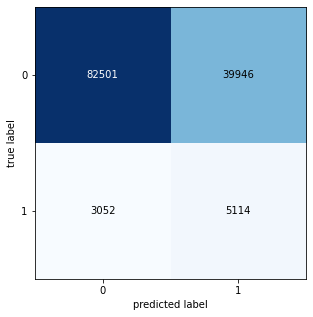

In [11]:
pipeline.fit(train_sentences,train_labels)
pred=pipeline.predict(val_sentences)

from sklearn.metrics import accuracy_score
print('Test Accuracy using MultiNomial Naive Bayes Classifier: ',accuracy_score(val_labels,pred))

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred))
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred))
CM = confusion_matrix(val_labels, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### **While the classifier has a high accuracy, it fails to classify  even a single example from the minority class **

## **Logistic Regression**

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
pipeline=Pipeline([('bow',CountVectorizer(analyzer=clean_text)),
                   ('tfidf',TfidfTransformer()),
                   ('classifier',LogisticRegression())
                   ])

Test Accuracy using Logistic Regression Classifier:  0.9388719257470112
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    123617
           1       0.39      0.00      0.00      8041

    accuracy                           0.94    131658
   macro avg       0.66      0.50      0.49    131658
weighted avg       0.91      0.94      0.91    131658

[[123598     19]
 [  8029     12]]


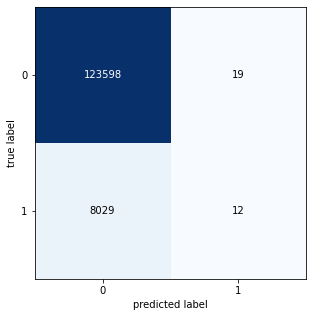

In [13]:
pipeline.fit(train_sentences,train_labels)
pred=pipeline.predict(test_sentences)

from sklearn.metrics import accuracy_score
print('Test Accuracy using Logistic Regression Classifier: ',accuracy_score(test_labels,pred))

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
print(classification_report(test_labels,pred))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels, pred))
CM = confusion_matrix(test_labels, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

### **This classifier could classify a few instances of the minority class. Yet, the results are abysmal.**

# **Word Embedding Models**

In [14]:
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


embedding_dim = 300
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_len=49999


tokenizer = Tokenizer(num_words=vocab_len+1,oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print('Original Size of Vocabulary: ',vocab_size)

word_index = {e:i for e,i in word_index.items() if i <= vocab_len+1} #Reducing the Size of Vocabulary
print('New Size of Vocabulary: ',len(word_index))

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


train_labels=np.expand_dims(train_labels, axis=1)
val_labels=np.expand_dims(val_labels, axis=1)
test_labels=np.expand_dims(test_labels, axis=1)

Original Size of Vocabulary:  178874
New Size of Vocabulary:  50000


In [15]:
#Dimension of Data after Tokenizing and Padding
print('Dimension of Training Data: ',train_padded.shape)
print('Dimension of Validation Data: ',val_padded.shape)
print('Dimension of Training Labels: ',train_labels.shape)
print('Dimension of Validation Labels: ',val_labels.shape)

Dimension of Training Data:  (1043851, 100)
Dimension of Validation Data:  (130613, 100)
Dimension of Training Labels:  (1043851, 1)
Dimension of Validation Labels:  (130613, 1)


## **Bidirectional LSTM Model**

In [16]:
#Building the Bidirectional LSTM Model
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional((LSTM(20, return_sequences=True))),
    tf.keras.layers.Bidirectional((LSTM(10, return_sequences=True))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 40)           51360     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 20)           4080      
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                32016     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [18]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 2
history=model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=512, validation_data=(val_padded,val_labels),callbacks=[reduce],verbose=1)

Epoch 1/2
2039/2039 [==============================] - 2297s 1s/step - loss: 0.1426 - accuracy: 0.9469 - val_loss: 0.1125 - val_accuracy: 0.9556
Epoch 2/2
2039/2039 [==============================] - 2885s 1s/step - loss: 0.0959 - accuracy: 0.9615 - val_loss: 0.1078 - val_accuracy: 0.9575


In [19]:
#Determining the optimal threshold value to seggregate the classes
pred1 = model.predict(val_padded, batch_size=512,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred1>thresh).astype(int))))

256/256 [==============================] - 68s 257ms/step
F1 score at threshold 0.1 is 0.5646883341183859
F1 score at threshold 0.11 is 0.5736271705410741
F1 score at threshold 0.12 is 0.5825394861643779
F1 score at threshold 0.13 is 0.5903878583473862
F1 score at threshold 0.14 is 0.5974193548387097
F1 score at threshold 0.15 is 0.6035259635154644
F1 score at threshold 0.16 is 0.6100200400801603
F1 score at threshold 0.17 is 0.6146950971071574
F1 score at threshold 0.18 is 0.6193388201756403
F1 score at threshold 0.19 is 0.62337904655285
F1 score at threshold 0.2 is 0.6278188364601099
F1 score at threshold 0.21 is 0.6311893087203154
F1 score at threshold 0.22 is 0.6345835362883585
F1 score at threshold 0.23 is 0.6371532918764189
F1 score at threshold 0.24 is 0.64007996001999
F1 score at threshold 0.25 is 0.642795731553128
F1 score at threshold 0.26 is 0.6453893442622951
F1 score at threshold 0.27 is 0.6462479270315092
F1 score at threshold 0.28 is 0.6468214454169068
F1 score at thresh

256/256 [==============================] - 56s 217ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122447
           1       0.59      0.72      0.65      8166

    accuracy                           0.95    130613
   macro avg       0.78      0.84      0.81    130613
weighted avg       0.96      0.95      0.95    130613

[[118292   4155]
 [  2257   5909]]


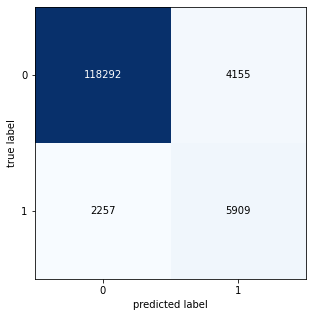

In [20]:
# From above, we can see that F1 score is highest at a threshold of 0.32
pred1 = model.predict(val_padded, batch_size=512,verbose=1)
pred_val_labels=(pred1>0.32).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels))
CM = confusion_matrix(val_labels, pred_val_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

## **Bidirectional GRU**

In [ ]:
#Building the Bidirectional GRU Model
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional((tf.keras.layers.GRU(20, return_sequences=True))),      
    tf.keras.layers.Bidirectional((tf.keras.layers.GRU(20, return_sequences=True))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [62]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 40)           38640     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 40)           7440      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                64016     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model_gru.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
num_epochs = 2
history_gru=model_gru.fit(train_padded, train_labels, epochs=num_epochs, batch_size=512, validation_data=(val_padded,val_labels),callbacks=[reduce],verbose=1)

Epoch 1/3
2039/2039 [==============================] - 2595s 1s/step - loss: 0.1400 - accuracy: 0.9496 - val_loss: 0.1160 - val_accuracy: 0.9549
Epoch 2/3
2039/2039 [==============================] - 2351s 1s/step - loss: 0.1122 - accuracy: 0.9570 - val_loss: 0.1197 - val_accuracy: 0.9554
Epoch 3/3
2039/2039 [==============================] - 2369s 1s/step - loss: 0.1069 - accuracy: 0.9592 - val_loss: 0.1119 - val_accuracy: 0.9563


In [23]:
#Determining the optimal threshold value to seggregate the classes
pred2 = model_gru.predict(val_padded, batch_size=512,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.5, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred2>thresh).astype(int))))

256/256 [==============================] - 76s 293ms/step
F1 score at threshold 0.1 is 0.5633089476646033
F1 score at threshold 0.15 is 0.6005219582433404
F1 score at threshold 0.2 is 0.623897040900892
F1 score at threshold 0.25 is 0.6376312078959737
F1 score at threshold 0.3 is 0.6426156830146855
F1 score at threshold 0.35 is 0.6425233644859814
F1 score at threshold 0.4 is 0.6381860408263049
F1 score at threshold 0.45 is 0.6309996160245746


              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122447
           1       0.59      0.71      0.64      8166

    accuracy                           0.95    130613
   macro avg       0.78      0.84      0.81    130613
weighted avg       0.96      0.95      0.95    130613

[[118366   4081]
 [  2368   5798]]


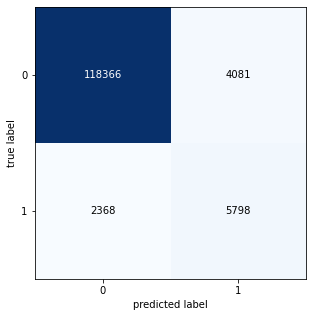

In [24]:
# From above, we can see that F1 score is highest at a threshold of 0.3
pred_val_labels_gru=(pred2>0.3).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels_gru))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels_gru))
CM = confusion_matrix(val_labels, pred_val_labels_gru)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

# **Pretrained Word Embeddings**

## Glove  word2vec

**GLOVE-300d-2M**

In [25]:
embeddings_index = {}
with open("E:\\quora_data_set\\embeddings\\glove.840B.300d\\glove.840B.300d.txt",encoding="utf8") as f:
    for line in f:
        values = line.split()
        #print(values)
        word = values[0]
        #print(word)
        try:
            coefs = np.asarray(values[1:], dtype='float32')            
            embeddings_index[word] = coefs
        except ValueError:
            print(word)
f.close()

.
at
.
to
.
.
email
or
contact
Email
on
At
by
in
emailing
Contact
at
•
at
is


In [26]:
# Creating an embedding matrix that contains the vectors of the words in the dataset
embeddings_matrix = np.zeros((vocab_len+2, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [27]:
embeddings_matrix=np.delete(embeddings_matrix, 1, 0)

In [28]:
print('Shape of the Embeddings Matrix: ',embeddings_matrix.shape)

Shape of the Embeddings Matrix:  (50000, 300)


## **Bidirectional LSTM**

In [ ]:
model3_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len+1, embedding_dim,weights=[embeddings_matrix], input_length=max_length),
    tf.keras.layers.Bidirectional((LSTM(20, return_sequences=True))),
    tf.keras.layers.Bidirectional((LSTM(10, return_sequences=True))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [63]:
model3_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 40)           51360     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 20)           4080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                32016     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model3_lstm.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
num_epochs = 3
history3=model3_lstm.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=512, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Epoch 1/3
2039/2039 [==============================] - 2816s 1s/step - loss: 0.1480 - accuracy: 0.9480 - val_loss: 0.1150 - val_accuracy: 0.9546
Epoch 2/3
2039/2039 [==============================] - 2731s 1s/step - loss: 0.1115 - accuracy: 0.9567 - val_loss: 0.1135 - val_accuracy: 0.9559
Epoch 3/3
2039/2039 [==============================] - 2728s 1s/step - loss: 0.1057 - accuracy: 0.9591 - val_loss: 0.1118 - val_accuracy: 0.9558


In [31]:
#Determining the optimal threshold value to seggregate the classes
pred3= model3_lstm.predict(val_padded, batch_size=512,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.5, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred3>thresh).astype(int))))

256/256 [==============================] - 95s 362ms/step
F1 score at threshold 0.1 is 0.5486483403672864
F1 score at threshold 0.15 is 0.5857818304626816
F1 score at threshold 0.2 is 0.610115528063313
F1 score at threshold 0.25 is 0.6276106023162281
F1 score at threshold 0.3 is 0.6369616610134649
F1 score at threshold 0.35 is 0.6434904844290656
F1 score at threshold 0.4 is 0.6464886923992519
F1 score at threshold 0.45 is 0.6466824644549763


              precision    recall  f1-score   support

           0       0.98      0.96      0.97    122447
           1       0.55      0.76      0.64      8166

    accuracy                           0.95    130613
   macro avg       0.77      0.86      0.80    130613
weighted avg       0.96      0.95      0.95    130613

[[117352   5095]
 [  1969   6197]]


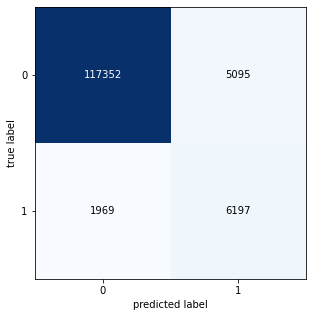

In [32]:
#From above, we can see that F1 score is highest at a threshold of 0.3
pred_ft3_val_labels=(pred3>0.3).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_ft3_val_labels))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_ft3_val_labels))
CM = confusion_matrix(val_labels, pred_ft3_val_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

## **Bidirectional GRU**

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len+1, embedding_dim,weights=[embeddings_matrix], input_length=max_length),
    tf.keras.layers.Bidirectional((tf.keras.layers.GRU(20, return_sequences=True))),      
    tf.keras.layers.Bidirectional((tf.keras.layers.GRU(20, return_sequences=True))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [64]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 40)           38640     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 40)           7440      
_________________________________________________________________
flatten_3 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                64016     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [34]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model4.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
num_epochs = 5
history4=model4.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=512, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Epoch 1/5
2039/2039 [==============================] - 3465s 2s/step - loss: 0.1506 - accuracy: 0.9443 - val_loss: 0.1156 - val_accuracy: 0.9544
Epoch 2/5
2039/2039 [==============================] - 3529s 2s/step - loss: 0.1129 - accuracy: 0.9561 - val_loss: 0.1119 - val_accuracy: 0.9558
Epoch 3/5
2039/2039 [==============================] - 3503s 2s/step - loss: 0.1065 - accuracy: 0.9587 - val_loss: 0.1115 - val_accuracy: 0.9559
Epoch 4/5
2039/2039 [==============================] - 3507s 2s/step - loss: 0.1028 - accuracy: 0.9603 - val_loss: 0.1130 - val_accuracy: 0.9551
Epoch 5/5
2039/2039 [==============================] - 3500s 2s/step - loss: 0.0971 - accuracy: 0.9627 - val_loss: 0.1151 - val_accuracy: 0.9556


In [35]:
#Determining the optimal threshold value to seggregate the classes
pred4 = model4.predict(val_padded, batch_size=512,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.5, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred4>thresh).astype(int))))

256/256 [==============================] - 120s 463ms/step
F1 score at threshold 0.1 is 0.5913331589502137
F1 score at threshold 0.15 is 0.6168529087333942
F1 score at threshold 0.2 is 0.6315843568528702
F1 score at threshold 0.25 is 0.636981460338172
F1 score at threshold 0.3 is 0.6370949207078832
F1 score at threshold 0.35 is 0.6339984231912185
F1 score at threshold 0.4 is 0.619870271658853
F1 score at threshold 0.45 is 0.605568445475638


              precision    recall  f1-score   support

           0       0.98      0.97      0.98    122447
           1       0.63      0.64      0.63      8166

    accuracy                           0.95    130613
   macro avg       0.80      0.81      0.80    130613
weighted avg       0.95      0.95      0.95    130613

[[119351   3096]
 [  2939   5227]]


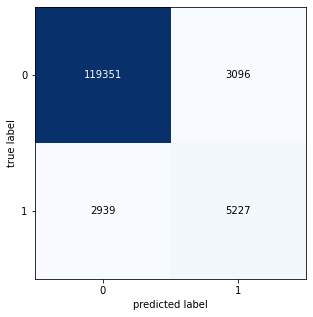

In [36]:
#From above, we can see that F1 score is highest at a threshold of 0.35
pred_ft4_val_labels=(pred4>0.35).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_ft4_val_labels))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_ft4_val_labels))
CM = confusion_matrix(val_labels, pred_ft4_val_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

# **Final Model**

###**Though the results of the above models are similar, there is a good chance that they might capture different type of information from the data. So, the final model is a blend of the 4 previous models.**

In [37]:
pred_final = 0.34*pred1 + 0.22*pred2 + 0.22*pred3 + 0.22*pred4
for thresh in np.arange(0.1, 0.501, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred_final>thresh).astype(int))))

F1 score at threshold 0.1 is 0.5711806924836343
F1 score at threshold 0.15 is 0.6124034429485765
F1 score at threshold 0.2 is 0.6373193797705343
F1 score at threshold 0.25 is 0.6525751404856421
F1 score at threshold 0.3 is 0.6590386510456586
F1 score at threshold 0.35 is 0.6582337240338864
F1 score at threshold 0.4 is 0.6552402014989556
F1 score at threshold 0.45 is 0.6426625145971194
F1 score at threshold 0.5 is 0.6228877593075972


              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122447
           1       0.60      0.74      0.66      8166

    accuracy                           0.95    130613
   macro avg       0.79      0.85      0.82    130613
weighted avg       0.96      0.95      0.95    130613

[[118366   4081]
 [  2147   6019]]


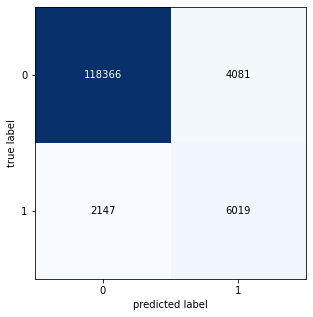

In [56]:
pred_final_val_labels=(pred_final>0.3).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_final_val_labels))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_final_val_labels))
CM = confusion_matrix(val_labels, pred_final_val_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [39]:
pred1_l = model.predict(test_padded, batch_size=512,verbose=1)
pred2_l = model_gru.predict(test_padded, batch_size=512,verbose=1)
pred3_l = model3_lstm.predict(test_padded, batch_size=512,verbose=1)
pred4_l = model4.predict(test_padded, batch_size=512,verbose=1)

258/258 [==============================] - 111s 431ms/step


              precision    recall  f1-score   support

           0       0.98      0.97      0.98    123617
           1       0.61      0.69      0.65      8041

    accuracy                           0.95    131658
   macro avg       0.79      0.83      0.81    131658
weighted avg       0.96      0.95      0.96    131658

[[119977   3640]
 [  2460   5581]]


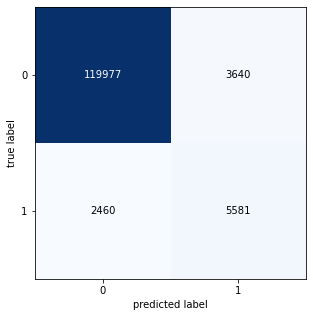

In [61]:
pred_test_labels = pred1_l 
pred_test_labels = (pred_test_labels>0.35).astype(int)
print(classification_report(test_labels, pred_test_labels))
print(confusion_matrix(test_labels, pred_test_labels))
CM = confusion_matrix(test_labels, pred_test_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    123617
           1       0.60      0.67      0.64      8041

    accuracy                           0.95    131658
   macro avg       0.79      0.82      0.81    131658
weighted avg       0.96      0.95      0.95    131658

[[120039   3578]
 [  2618   5423]]


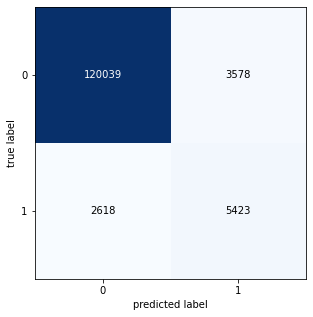

In [70]:
pred_test_labels = pred2_l 
pred_test_labels = (pred_test_labels>0.35).astype(int)
print(classification_report(test_labels, pred_test_labels))
print(confusion_matrix(test_labels, pred_test_labels))
CM = confusion_matrix(test_labels, pred_test_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    123617
           1       0.57      0.72      0.64      8041

    accuracy                           0.95    131658
   macro avg       0.78      0.84      0.81    131658
weighted avg       0.96      0.95      0.95    131658

[[119209   4408]
 [  2217   5824]]


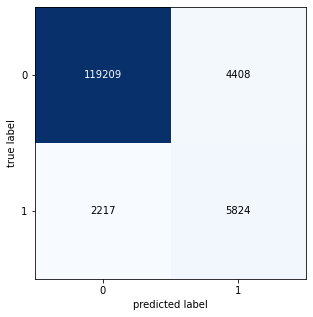

In [72]:
pred_test_labels = pred3_l 
pred_test_labels = (pred_test_labels>0.35).astype(int)
print(classification_report(test_labels, pred_test_labels))
print(confusion_matrix(test_labels, pred_test_labels))
CM = confusion_matrix(test_labels, pred_test_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    123617
           1       0.62      0.63      0.63      8041

    accuracy                           0.95    131658
   macro avg       0.80      0.80      0.80    131658
weighted avg       0.95      0.95      0.95    131658

[[120514   3103]
 [  2943   5098]]


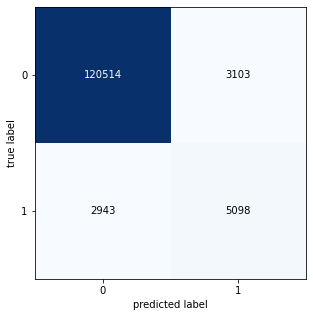

In [71]:
pred_test_labels = pred4_l 
pred_test_labels = (pred_test_labels>0.35).astype(int)
print(classification_report(test_labels, pred_test_labels))
print(confusion_matrix(test_labels, pred_test_labels))
CM = confusion_matrix(test_labels, pred_test_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    123617
           1       0.62      0.69      0.65      8041

    accuracy                           0.96    131658
   macro avg       0.80      0.83      0.81    131658
weighted avg       0.96      0.96      0.96    131658

[[120183   3434]
 [  2474   5567]]


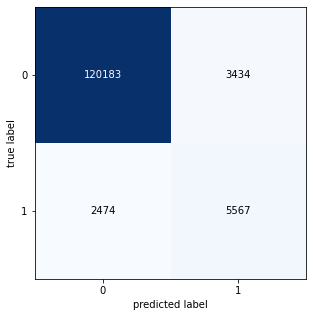

In [74]:
pred_test_labels = 0.34*pred1_l + 0.22*pred2_l + 0.22*pred3_l + 0.22*pred4_l
pred_test_labels = (pred_test_labels>0.35).astype(int)
print(classification_report(test_labels, pred_test_labels))
print(confusion_matrix(test_labels, pred_test_labels))
CM = confusion_matrix(test_labels, pred_test_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()